In [10]:
import pandas as pd
import sys
import os
import json
import pandas
import numpy
import optparse

from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout,SimpleRNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Bidirectional

In [4]:
df = pd.read_csv('Tetuan City power consumption.csv')

In [5]:
df.isnull().sum()

DateTime                     0
Temperature                  0
Humidity                     0
Wind Speed                   0
general diffuse flows        0
diffuse flows                0
Zone 1 Power Consumption     0
Zone 2  Power Consumption    0
Zone 3  Power Consumption    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTime                   52416 non-null  object 
 1   Temperature                52416 non-null  float64
 2   Humidity                   52416 non-null  float64
 3   Wind Speed                 52416 non-null  float64
 4   general diffuse flows      52416 non-null  float64
 5   diffuse flows              52416 non-null  float64
 6   Zone 1 Power Consumption   52416 non-null  float64
 7   Zone 2  Power Consumption  52416 non-null  float64
 8   Zone 3  Power Consumption  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [8]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.sort_values(by="DateTime", inplace=True)

In [9]:
df['DateTime']

0       2017-01-01 00:00:00
1       2017-01-01 00:10:00
2       2017-01-01 00:20:00
3       2017-01-01 00:30:00
4       2017-01-01 00:40:00
                ...        
52411   2017-12-30 23:10:00
52412   2017-12-30 23:20:00
52413   2017-12-30 23:30:00
52414   2017-12-30 23:40:00
52415   2017-12-30 23:50:00
Name: DateTime, Length: 52416, dtype: datetime64[ns]

<AxesSubplot:xlabel='DateTime', ylabel='Zone 1 Power Consumption'>

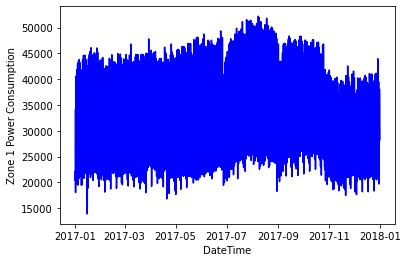

In [11]:
# Plot Zone 1 Power Consumption
sns.lineplot(x='DateTime', y='Zone 1 Power Consumption', color='b', data=df)

<AxesSubplot:xlabel='DateTime', ylabel='Zone 2  Power Consumption'>

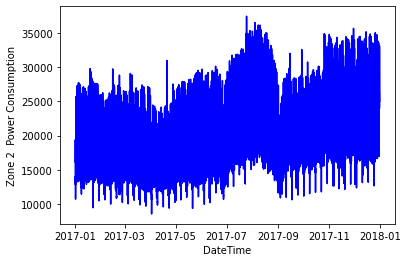

In [13]:
# Plot Zone 2 Power Consumption
sns.lineplot(x='DateTime', y='Zone 2  Power Consumption', color='b', data=df)

<AxesSubplot:xlabel='DateTime', ylabel='Zone 3  Power Consumption'>

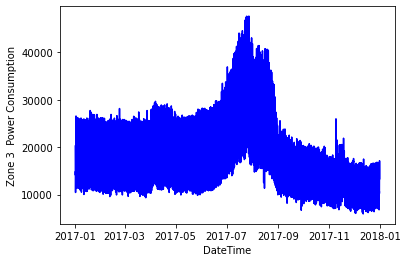

In [14]:
# Plot Zone 2 Power Consumption
sns.lineplot(x='DateTime', y='Zone 3  Power Consumption', color='b', data=df)

In [15]:
import pandas as pd
import numpy as np
from typing import Tuple


def create_data_for_NN(
    data: pd.DataFrame, Y_var: str, lag: int, test_ratio: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    """Function to return lagged time series data after train-test split

    Args:
        data (pd.DataFrame): Raw time series data frame
        Y_var (str): String with the name of y variable
        lag (int): number of lagged records to consider
        test_ratio (float): ratio of data to consider for test set

    Returns:
        Tuple[np.array, np.array, np.array, np.array]: Lagged and split numpy arrays
    """
    y = data[Y_var].tolist()

    X, Y = [], []

    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Creating training and test sets
    X_train = X
    X_test = []

    Y_train = Y
    Y_test = []

    if test_ratio > 0:
        index = round(len(X) * test_ratio)
        X_train = X[: (len(X) - index)]
        X_test = X[-index:]

        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]

    return X_train, X_test, Y_train, Y_test

In [25]:
lag = 3
test_ratio = 0.15

X_train, X_test, Y_train, Y_test = create_data_for_NN(
    df, df.columns[6], lag, test_ratio
)

In [26]:
max_value = np.max(df['Zone 1 Power Consumption'])
X_train = X_train / max_value
Y_train = Y_train / max_value
X_test = X_test / max_value
Y_test = Y_test / max_value

In [27]:
model1 = Sequential()
model1.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='sgd', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model1.fit(X_train, Y_train, batch_size=128, epochs=30, validation_split=0.25)

Epoch 1/30
262/262 [==============================] - 2s 4ms/step - loss: 0.0309 - root_mean_squared_error: 0.1758 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0970
Epoch 2/30
262/262 [==============================] - 1s 3ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0911
Epoch 3/30
262/262 [==============================] - 1s 3ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0853
Epoch 4/30
262/262 [==============================] - 1s 3ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 5/30
262/262 [==============================] - 1s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0745
Epoch 6/30
262/262 [==============================] - 1s 3ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0048 - val_

In [28]:
predict1 = model1.predict(X_test)
predict1 = predict1 * max_value
predict1

array([[25133.516],
       [25622.287],
       [26247.883],
       ...,
       [31207.754],
       [30408.314],
       [29721.031]], dtype=float32)

In [29]:
Y_test = Y_test * max_value

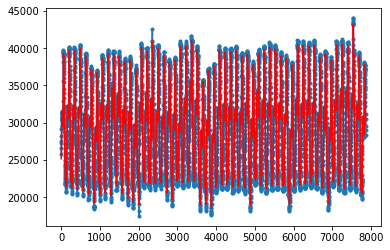

In [31]:
plt.plot(Y_test, marker='.')
plt.plot(predict1, 'r')
plt.show()